<h4>Лабороторная работа 1 👩‍💻 <h4>

Описание:
- BatchNorm1d ускоряет обучение за счет стабилизации распределения активаций.
- Dropout добавляет регуляризацию, предотвращая переобучение.
- Adam выбран за способность к быстрой сходимости при невысокой чувствительности к выбору гиперпараметров.



<h4>Импорты<h4>

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim


<h4>Константы<h4>

In [4]:
PATH = 'cybersequrity.csv'
EPOCHS=20
RANDOM_STATE = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
set_seed(RANDOM_STATE)

<h4>Просмотр данных<h4>

In [8]:
data = pd.read_csv(PATH)
 
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   svcscan.fs_drivers                      10000 non-null  int64  
 1   callbacks.ngeneric                      10000 non-null  int64  
 2   psxview.not_in_eprocess_pool_false_avg  10000 non-null  float64
 3   psxview.not_in_eprocess_pool            10000 non-null  int64  
 4   callbacks.nanonymous                    10000 non-null  int64  
 5   psxview.not_in_session                  10000 non-null  int64  
 6   psxview.not_in_pslist                   10000 non-null  int64  
 7   psxview.not_in_pspcid_list              10000 non-null  int64  
 8   psxview.not_in_ethread_pool             10000 non-null  int64  
 9   psxview.not_in_csrss_handles            10000 non-null  int64  
 10  psxview.not_in_pslist_false_avg         10000 non-null  flo

(   svcscan.fs_drivers  callbacks.ngeneric  \
 0                  26                   8   
 1                  26                   8   
 2                  26                   8   
 3                  26                   8   
 4                  26                   8   
 
    psxview.not_in_eprocess_pool_false_avg  psxview.not_in_eprocess_pool  \
 0                                     0.0                             0   
 1                                     0.0                             0   
 2                                     0.0                             0   
 3                                     0.0                             0   
 4                                     0.0                             0   
 
    callbacks.nanonymous  psxview.not_in_session  psxview.not_in_pslist  \
 0                     0                       2                      0   
 1                     0                       5                      3   
 2                     0               

In [9]:
X = data.drop(columns=['Class'])
y = data['Class']

<h4>Разделение датасета<h4>

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

Стандартизация функции с помощью StandardScaler

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Проверка размеров

In [12]:
len(X_train), len(X_val), len(X_test)

(6000, 2000, 2000)

Данные разделены:

Обучающая выборка: 6000 

Валидационная выборка: 2000 

Тестовая выборка: 2000 

In [13]:
class MalwareDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

<h4>Создание датасета<h4>

In [14]:
train_dataset = MalwareDataset(X_train_scaled, y_train)
val_dataset = MalwareDataset(X_val_scaled, y_val)
test_dataset = MalwareDataset(X_test_scaled, y_test)

In [15]:
batch_size = 64

Это стандартный размер батча, который эффективно работает на большинстве задач. Он достаточен для стабильного обучения, при этом не слишком велик, чтобы не перегрузить память.

Создание Data Loaders

In [16]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Проверка одного пакета

In [17]:
next(iter(train_loader))

[tensor([[ 1.7228e-02,  1.8260e-02, -5.8698e-02, -4.4766e-02, -2.8880e-02,
          -6.1347e-01, -6.1364e-01, -6.1352e-01, -4.9217e-01, -4.9267e-01,
          -7.0467e-01, -7.0452e-01, -4.7654e-01, -7.0482e-01, -7.0415e-01],
         [ 1.7228e-02,  1.8260e-02, -5.8698e-02, -4.4766e-02, -2.8880e-02,
           5.5466e-02,  5.5299e-02,  5.5410e-02,  3.8449e-01,  3.8358e-01,
          -1.0897e-01, -1.0882e-01,  3.7639e-01,  3.4563e-01, -4.5291e-01],
         [ 1.7228e-02,  1.8260e-02, -5.8698e-02, -4.4766e-02, -2.8880e-02,
           5.5466e-02,  5.5299e-02,  5.5410e-02, -5.3842e-02, -5.4547e-02,
           3.4603e-01,  3.4619e-01, -5.0074e-02,  1.9065e-01,  3.2688e-01],
         [ 1.7228e-02,  1.8260e-02, -5.8698e-02, -4.4766e-02, -2.8880e-02,
           5.5466e-02,  5.5299e-02,  5.5410e-02, -5.3842e-02, -5.4547e-02,
          -2.7681e-02, -2.7528e-02, -5.0074e-02, -1.2785e-01, -1.8634e-01],
         [ 1.7228e-02,  1.8260e-02, -5.8698e-02, -4.4766e-02, -2.8880e-02,
          -6.1347e-01

<h4>Базовый класс модели<h4>

In [18]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

Инициализация

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPModel(input_dim=X_train_scaled.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Описание модели

In [20]:
print(model)

MLPModel(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


<h4>Циклы обучения и валидации<h4>

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
       
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze(1)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
        
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

<h4>Обучение модели<h4>

In [22]:
model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)

Epoch [1/20], Train Loss: 0.6898, Val Loss: 0.6771
Epoch [2/20], Train Loss: 0.6709, Val Loss: 0.6642
Epoch [3/20], Train Loss: 0.6576, Val Loss: 0.6533
Epoch [4/20], Train Loss: 0.6475, Val Loss: 0.6440
Epoch [5/20], Train Loss: 0.6398, Val Loss: 0.6387
Epoch [6/20], Train Loss: 0.6333, Val Loss: 0.6330
Epoch [7/20], Train Loss: 0.6281, Val Loss: 0.6258
Epoch [8/20], Train Loss: 0.6211, Val Loss: 0.6184
Epoch [9/20], Train Loss: 0.6146, Val Loss: 0.6142
Epoch [10/20], Train Loss: 0.6072, Val Loss: 0.6036
Epoch [11/20], Train Loss: 0.6004, Val Loss: 0.5981
Epoch [12/20], Train Loss: 0.5936, Val Loss: 0.5899
Epoch [13/20], Train Loss: 0.5879, Val Loss: 0.5833
Epoch [14/20], Train Loss: 0.5798, Val Loss: 0.5765
Epoch [15/20], Train Loss: 0.5750, Val Loss: 0.5786
Epoch [16/20], Train Loss: 0.5688, Val Loss: 0.5640
Epoch [17/20], Train Loss: 0.5625, Val Loss: 0.5593
Epoch [18/20], Train Loss: 0.5586, Val Loss: 0.5539
Epoch [19/20], Train Loss: 0.5535, Val Loss: 0.5485
Epoch [20/20], Train 

<h4>Визуализация обучения и валидации<h4>

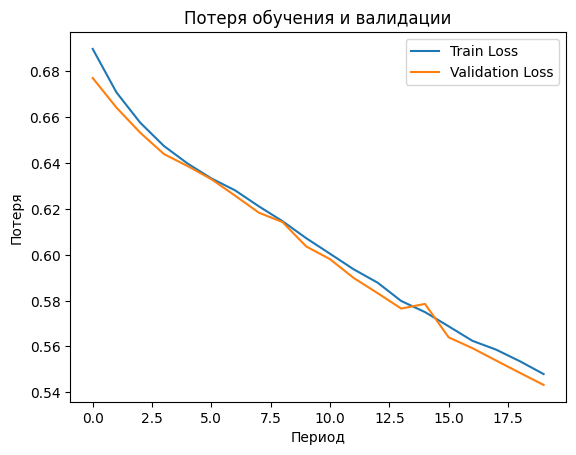

In [23]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Период')
plt.ylabel('Потеря')
plt.legend()
plt.title('Потеря обучения и валидации')
plt.show()

<h4>Вывод<h4>

Модель демонстрирует хорошую сходимость и стабильное обучение.
Отсутствие явного разрыва между обучающими и валидационными потерями показывает то, что модель не переобучается.

На данном этапе обучение можно считать успешным, но если метрики на тестовой выборке недостаточны. Можно сделать:

- Увеличить количество эпох, чтобы достичь более низких значений функции потерь.
- Экспериментировать с архитектурой модели (например, изменять количество слоёв или параметр dropout).
- Регулировать скорость обучения для ускорения сходимости.

<h4>Оценка модели на тестовой выборки<h4>

In [24]:
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze(1)
            preds = (outputs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    return classification_report(all_labels, all_preds)


In [25]:
classification_report_str = evaluate_model(model, test_loader)
print(classification_report_str)

              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75       981
         1.0       0.78      0.71      0.74      1019

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



<h4>Улучшение модели (BatchNorm и Dropout)<h4>

In [26]:
class ImprovedMLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout_prob=0.3):
        super(ImprovedMLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

<h4>Эксперименты для Dropout<h4>


Модель обучения p=0.1
Epoch [1/20], Train Loss: 0.5985, Val Loss: 0.5961
Epoch [2/20], Train Loss: 0.5381, Val Loss: 0.5879
Epoch [3/20], Train Loss: 0.5101, Val Loss: 0.5036
Epoch [4/20], Train Loss: 0.4957, Val Loss: 0.5358
Epoch [5/20], Train Loss: 0.4840, Val Loss: 0.5076
Epoch [6/20], Train Loss: 0.4785, Val Loss: 0.4810
Epoch [7/20], Train Loss: 0.4784, Val Loss: 0.5178
Epoch [8/20], Train Loss: 0.4623, Val Loss: 0.5792
Epoch [9/20], Train Loss: 0.4673, Val Loss: 0.4579
Epoch [10/20], Train Loss: 0.4573, Val Loss: 0.4907
Epoch [11/20], Train Loss: 0.4601, Val Loss: 0.4452
Epoch [12/20], Train Loss: 0.4531, Val Loss: 0.4789
Epoch [13/20], Train Loss: 0.4509, Val Loss: 0.4543
Epoch [14/20], Train Loss: 0.4390, Val Loss: 0.4134
Epoch [15/20], Train Loss: 0.4377, Val Loss: 0.4664
Epoch [16/20], Train Loss: 0.4422, Val Loss: 0.4518
Epoch [17/20], Train Loss: 0.4400, Val Loss: 0.4511
Epoch [18/20], Train Loss: 0.4415, Val Loss: 0.4742
Epoch [19/20], Train Loss: 0.4322, Val Loss: 0.436

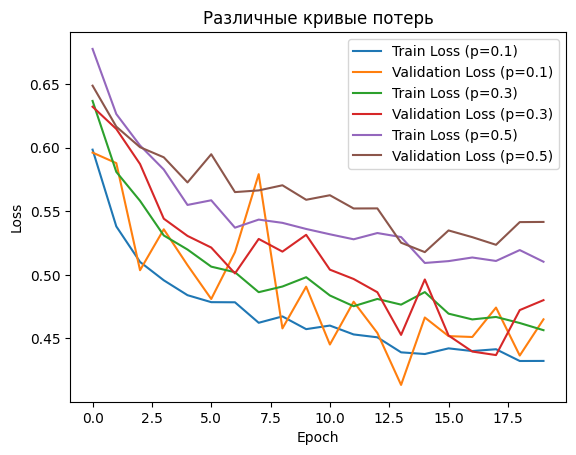

Отчет:

              precision    recall  f1-score   support

         0.0       0.69      0.89      0.78       981
         1.0       0.85      0.62      0.71      1019

    accuracy                           0.75      2000
   macro avg       0.77      0.75      0.74      2000
weighted avg       0.77      0.75      0.74      2000



In [32]:
dropout_values = [0.1, 0.3, 0.5]
best_model = None
best_report = None
best_val_loss = float('inf')


for p in dropout_values:
    print(f"\nМодель обучения p={p}")
    
    model = ImprovedMLPModel(input_dim=X_train_scaled.shape[1], dropout_prob=p).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model, train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS
    )
    
    plt.plot(train_losses, label=f'Train Loss (p={p})')
    plt.plot(val_losses, label=f'Validation Loss (p={p})')
    
    report = evaluate_model(model, test_loader)
    print(f"\nОтчет p={p}:\n{report}")
    
    if min(val_losses) < best_val_loss:
        best_val_loss = min(val_losses)
        best_model = model
        best_report = report

                                                        #Графики и отчет
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Различные кривые потерь')
plt.show()


print("Отчет:\n")
print(best_report)

<h4>Вывод<h4>

Наилучший баланс между обучением и обобщением наблюдается при p=0.1.

Модель демонстрирует низкие значения потерь на обучающей и на валидационной выборках.

При p=0.3 модель показывает приемлемую регуляризацию, что подходит для предотвращения переобучения, но требует больше эпох для обучения.

При p=0.5 модель слишком сильно регуляризируется, что ухудшает её способность к обучению и обобщению.

После обучения модели на тренировочных и валидационных данных, измеряю её качество на тестовой выборке с помощью classification_report, который дает подробную информацию о точности, полноте, F1-мере и других метриках.

Precision и Recall важны в задачах классификации вредоносного ПО, где важно минимизировать как ложные срабатывания, так и пропуски.